# `neural_network_without_race_fake_data.ipynb`

### Author: Anthony Hein

#### Last updated: 12/4/2021

# Overview:

Feed in a neural network fake data to see how its predictions may change.

---

## Setup

In [1]:
import git
import os
import re
from typing import List
from tqdm import tqdm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
BASE_DIR = git.Repo(os.getcwd(), search_parent_directories=True).working_dir
BASE_DIR

'/Users/anthonyhein/Desktop/SML310/project'

---

## Load `X_train_preprocess_without_race.csv`

In [3]:
X_train = pd.read_csv(f"{BASE_DIR}/data/analysis/X_train_preprocess_without_race.csv", low_memory=False)
X_train.head()

,horse1_age,horse1_saddle,horse1_decimalPrice,horse1_isFav,horse1_outHandicap,horse1_RPR,horse1_weight,horse1_jockey_d_last_race,horse1_jockey_d_first_race,horse1_jockey_prev_1_position,...,horse2_jockey_prev_3_position_rain,horse2_jockey_prev_1_finishing_time_ratio_rain,horse2_jockey_prev_2_finishing_time_ratio_rain,horse2_jockey_prev_3_finishing_time_ratio_rain,horse2_jockey_prev_1_position_rhum,horse2_jockey_prev_2_position_rhum,horse2_jockey_prev_3_position_rhum,horse2_jockey_prev_1_finishing_time_ratio_rhum,horse2_jockey_prev_2_finishing_time_ratio_rhum,horse2_jockey_prev_3_finishing_time_ratio_rhum
0,0.200000,0.230769,0.196970,0.0,0.0,0.73125,0.692308,0.007631,0.236544,0.100,...,0.050,0.805104,0.780139,0.783438,0.100,0.025,0.025,0.805104,0.799642,0.780139
1,0.400000,0.038462,0.072222,0.0,0.0,0.73125,0.743590,0.005050,0.236544,0.100,...,0.100,0.801416,0.781238,0.794160,0.075,0.050,0.075,0.801416,0.800487,0.785703
2,0.133333,0.423077,0.098485,0.0,0.0,0.65000,0.705128,0.000740,0.237283,0.025,...,0.100,0.799909,0.780139,0.786816,0.025,0.100,0.025,0.799642,0.806486,0.780139
3,0.133333,0.423077,0.098485,0.0,0.0,0.65000,0.705128,0.000740,0.237283,0.025,...,0.075,0.800176,0.781623,0.781870,0.050,0.075,0.050,0.801163,0.801416,0.780963
4,0.133333,0.192308,0.090278,0.0,0.0,0.66250,0.730769,0.000740,0.234655,0.050,...,0.100,0.799642,0.783601,0.785468,0.125,0.100,0.025,0.803191,0.805104,0.780139


In [4]:
X_train.shape

(800666, 144)

---

## Load Neural Network

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Set the device to use
# CUDA refers to the GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Fixing Random Seed for Reproducibility
torch.manual_seed(0)
np.random.seed(0)

In [6]:
class Net(nn.Module):
    def __init__(self, input_size, num_layers, layers_size):
        super(Net, self).__init__()
        self.hidden_layers = nn.ModuleList([nn.Linear(input_size, layers_size)])
        self.hidden_layers.extend([nn.Linear(layers_size, layers_size) for i in range(1, num_layers-1)])
        self.output = nn.Linear(layers_size, 1)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        z = x
        for layer in self.hidden_layers:
            z = self.activation(layer(z))
        return self.output(z)

In [7]:
net = Net(X_train.shape[1], 1, 150)
net.load_state_dict(torch.load(f"{BASE_DIR}/data/analysis/neural_network/net_all_features_150_nodes.bin"))
net.eval()

Net(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=144, out_features=150, bias=True)
  )
  (output): Linear(in_features=150, out_features=1, bias=True)
  (activation): ReLU()
)

---

## Sample Data

In [8]:
X_train_sample = X_train.sample(frac=0.1)
X_train_sample.shape

(80067, 144)

---

## Create Dataframe where Each Input Has Equal Features

In [9]:
X_train_sample_eq = X_train_sample.copy()
X_train_sample_eq.shape

(80067, 144)

In [10]:
for column in X_train_sample_eq.columns:
    
    suffix = column[7:]
    copy_column = "horse1_" + suffix
    
    X_train_sample_eq[column] = X_train_sample_eq[copy_column]

---

## Predict on Equal-Feature Dataframe

In [11]:
X_train_sample_eq_tensor = torch.from_numpy(X_train_sample_eq.to_numpy()).float().to(device)

In [12]:
with torch.no_grad():
    eq_preds = torch.sigmoid(net.forward(X_train_sample_eq_tensor))

In [13]:
eq_preds.numpy()

array([[0.6177654 ],
       [0.6725244 ],
       [0.5644103 ],
       ...,
       [0.55897135],
       [0.46922383],
       [0.6743151 ]], dtype=float32)

In [14]:
torch.mean(eq_preds)

tensor(0.6172)

(array([5.0000e+00, 9.0000e+00, 4.5000e+01, 1.9200e+02, 1.3040e+03,
        1.0081e+04, 4.4625e+04, 2.2286e+04, 1.4150e+03, 1.0500e+02]),
 array([0.05277058, 0.13767469, 0.2225788 , 0.3074829 , 0.392387  ,
        0.4772911 , 0.56219524, 0.6470993 , 0.73200345, 0.8169075 ,
        0.90181166], dtype=float32),
 <BarContainer object of 10 artists>)

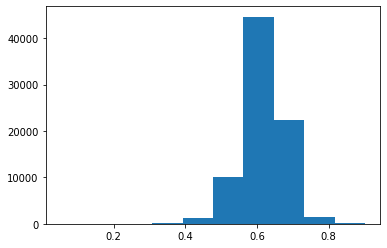

In [15]:
plt.hist(eq_preds.numpy())

---

## Create Dataframe with Exaggerated Differences Feature-Wise

In [285]:
list(X_train.columns)

['horse1_age',
 'horse1_saddle',
 'horse1_decimalPrice',
 'horse1_isFav',
 'horse1_outHandicap',
 'horse1_RPR',
 'horse1_weight',
 'horse1_jockey_d_last_race',
 'horse1_jockey_d_first_race',
 'horse1_jockey_prev_1_position',
 'horse1_jockey_prev_2_position',
 'horse1_jockey_prev_3_position',
 'horse1_jockey_prev_1_finishing_time_ratio',
 'horse1_jockey_prev_2_finishing_time_ratio',
 'horse1_jockey_prev_3_finishing_time_ratio',
 'horse1_jockey_prev_1_global_finishing_time_ratio',
 'horse1_jockey_prev_2_global_finishing_time_ratio',
 'horse1_jockey_prev_3_global_finishing_time_ratio',
 'horse1_jockey_prev_1_position_course',
 'horse1_jockey_prev_2_position_course',
 'horse1_jockey_prev_3_position_course',
 'horse1_jockey_prev_1_finishing_time_ratio_course',
 'horse1_jockey_prev_2_finishing_time_ratio_course',
 'horse1_jockey_prev_3_finishing_time_ratio_course',
 'horse1_jockey_prev_1_position_metric',
 'horse1_jockey_prev_2_position_metric',
 'horse1_jockey_prev_3_position_metric',
 'hor

### Odds & Ratings

(array([37326., 26524.,  9632.,  3000.,  1896.,   657.,   553.,   252.,
          189.,    38.]),
 array([0.00216234, 0.0982424 , 0.19432247, 0.29040253, 0.38648259,
        0.48256265, 0.57864271, 0.67472278, 0.77080284, 0.8668829 ,
        0.96296296]),
 <BarContainer object of 10 artists>)

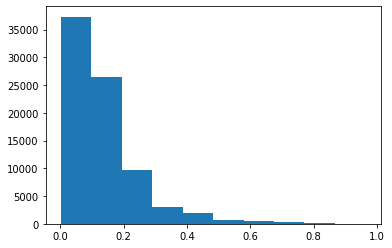

In [286]:
plt.hist(X_train_sample_eq['horse1_decimalPrice'])

(array([2.2310e+03, 5.5880e+03, 1.1680e+04, 1.9519e+04, 2.2014e+04,
        1.2500e+04, 5.5590e+03, 9.0500e+02, 6.8000e+01, 3.0000e+00]),
 array([-0.00625 ,  0.094375,  0.195   ,  0.295625,  0.39625 ,  0.496875,
         0.5975  ,  0.698125,  0.79875 ,  0.899375,  1.      ]),
 <BarContainer object of 10 artists>)

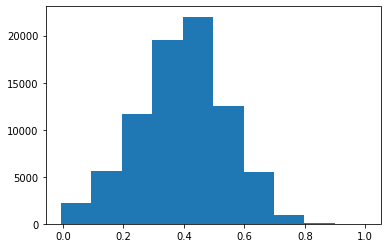

In [287]:
plt.hist(X_train_sample_eq['horse1_RPR'])

#### Small

In [288]:
odds_q_lo = X_train_sample_eq['horse1_decimalPrice'].quantile(q=1/3)
odds_q_lo

0.0722222222222221

In [289]:
odds_q_hi = X_train_sample_eq['horse1_decimalPrice'].quantile(q=2/3)
odds_q_hi

0.1354166666666666

In [290]:
rpr_q_lo = X_train_sample_eq['horse1_RPR'].quantile(q=1/3)
rpr_q_lo

0.3375

In [291]:
rpr_q_hi = X_train_sample_eq['horse1_RPR'].quantile(q=2/3)
rpr_q_hi

0.4625

In [292]:
X_train_sample_exagg = X_train_sample_eq.copy()
X_train_sample_exagg.shape

(80067, 144)

In [293]:
X_train_sample_exagg["horse1_decimalPrice"] = odds_q_hi
X_train_sample_exagg["horse2_decimalPrice"] = odds_q_lo
X_train_sample_exagg["horse1_RPR"] = rpr_q_hi
X_train_sample_exagg["horse2_RPR"] = rpr_q_lo

In [294]:
X_train_sample_exagg_tensor = torch.from_numpy(X_train_sample_exagg.to_numpy()).float().to(device)

In [295]:
with torch.no_grad():
    sample_exagg_preds = torch.sigmoid(net.forward(X_train_sample_exagg_tensor))

In [296]:
sample_exagg_preds.numpy()

array([[0.99994516],
       [0.99996173],
       [0.99896896],
       ...,
       [0.99824584],
       [0.9980217 ],
       [0.9993249 ]], dtype=float32)

In [297]:
torch.mean(sample_exagg_preds)

tensor(0.9996)

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 8.0065e+04]),
 array([0.66811985, 0.70130765, 0.7344955 , 0.7676833 , 0.80087113,
        0.834059  , 0.8672468 , 0.9004346 , 0.9336224 , 0.9668103 ,
        0.9999981 ], dtype=float32),
 <BarContainer object of 10 artists>)

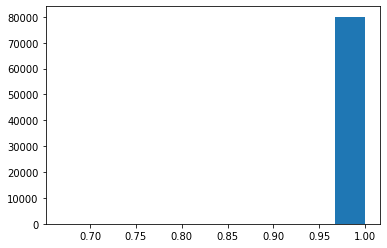

In [298]:
plt.hist(sample_exagg_preds.numpy())

In [299]:
torch.mean(abs(sample_exagg_preds - eq_preds))

tensor(0.3823)

#### Medium

In [300]:
odds_q_lo = X_train_sample_eq['horse1_decimalPrice'].quantile(q=1/4)
odds_q_lo

0.0637254901960784

In [301]:
odds_q_hi = X_train_sample_eq['horse1_decimalPrice'].quantile(q=3/4)
odds_q_hi

0.1666666666666665

In [302]:
rpr_q_lo = X_train_sample_eq['horse1_RPR'].quantile(q=1/4)
rpr_q_lo

0.3

In [303]:
rpr_q_hi = X_train_sample_eq['horse1_RPR'].quantile(q=3/4)
rpr_q_hi

0.49375

In [304]:
X_train_sample_exagg = X_train_sample_eq.copy()
X_train_sample_exagg.shape

(80067, 144)

In [305]:
X_train_sample_exagg["horse1_decimalPrice"] = odds_q_hi
X_train_sample_exagg["horse2_decimalPrice"] = odds_q_lo
X_train_sample_exagg["horse1_RPR"] = rpr_q_hi
X_train_sample_exagg["horse2_RPR"] = rpr_q_lo

In [306]:
X_train_sample_exagg_tensor = torch.from_numpy(X_train_sample_exagg.to_numpy()).float().to(device)

In [307]:
with torch.no_grad():
    sample_exagg_preds = torch.sigmoid(net.forward(X_train_sample_exagg_tensor))

In [308]:
sample_exagg_preds.numpy()

array([[0.9999993 ],
       [0.99999976],
       [0.99996567],
       ...,
       [0.99992204],
       [0.99990153],
       [0.9999664 ]], dtype=float32)

In [309]:
torch.mean(sample_exagg_preds)

tensor(1.0000)

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 8.0066e+04]),
 array([0.9759127 , 0.97832143, 0.9807302 , 0.98313886, 0.9855476 ,
        0.98795635, 0.9903651 , 0.99277383, 0.9951825 , 0.99759126,
        1.        ], dtype=float32),
 <BarContainer object of 10 artists>)

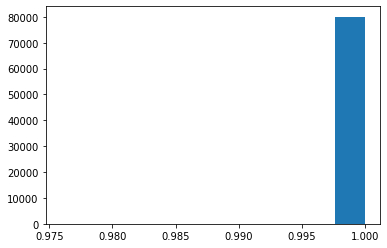

In [310]:
plt.hist(sample_exagg_preds.numpy())

In [311]:
torch.mean(abs(sample_exagg_preds - eq_preds))

tensor(0.3827)

#### High

In [312]:
odds_q_lo = X_train_sample_eq['horse1_decimalPrice'].quantile(q=1/5)
odds_q_lo

0.0515873015873015

In [313]:
odds_q_hi = X_train_sample_eq['horse1_decimalPrice'].quantile(q=4/5)
odds_q_hi

0.1969696969696969

In [314]:
rpr_q_lo = X_train_sample_eq['horse1_RPR'].quantile(q=1/5)
rpr_q_lo

0.275

In [315]:
rpr_q_hi = X_train_sample_eq['horse1_RPR'].quantile(q=4/5)
rpr_q_hi

0.5125

In [316]:
X_train_sample_exagg = X_train_sample_eq.copy()
X_train_sample_exagg.shape

(80067, 144)

In [317]:
X_train_sample_exagg["horse1_decimalPrice"] = odds_q_hi
X_train_sample_exagg["horse2_decimalPrice"] = odds_q_lo
X_train_sample_exagg["horse1_RPR"] = rpr_q_hi
X_train_sample_exagg["horse2_RPR"] = rpr_q_lo

In [318]:
X_train_sample_exagg_tensor = torch.from_numpy(X_train_sample_exagg.to_numpy()).float().to(device)

In [319]:
with torch.no_grad():
    sample_exagg_preds = torch.sigmoid(net.forward(X_train_sample_exagg_tensor))

In [320]:
sample_exagg_preds.numpy()

array([[1.        ],
       [1.        ],
       [0.99999726],
       ...,
       [0.9999938 ],
       [0.99998677],
       [0.99999654]], dtype=float32)

In [321]:
torch.mean(sample_exagg_preds)

tensor(1.0000)

(array([1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 8.0066e+04]),
 array([0.99640673, 0.9967661 , 0.9971254 , 0.9974847 , 0.99784404,
        0.9982034 , 0.9985627 , 0.998922  , 0.99928135, 0.9996407 ,
        1.        ], dtype=float32),
 <BarContainer object of 10 artists>)

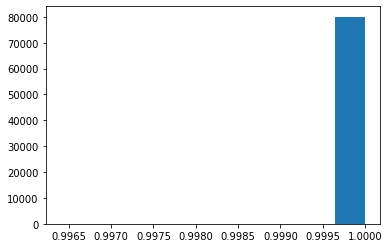

In [322]:
plt.hist(sample_exagg_preds.numpy())

In [323]:
torch.mean(abs(sample_exagg_preds - eq_preds))

tensor(0.3827)

### Unconditioned Previous Races

In [325]:
columns_horse1 = [
    'horse1_jockey_prev_1_position',
    'horse1_jockey_prev_2_position',
    'horse1_jockey_prev_3_position',
    'horse1_jockey_prev_1_finishing_time_ratio',
    'horse1_jockey_prev_2_finishing_time_ratio',
    'horse1_jockey_prev_3_finishing_time_ratio',
    'horse1_jockey_prev_1_global_finishing_time_ratio',
    'horse1_jockey_prev_2_global_finishing_time_ratio',
    'horse1_jockey_prev_3_global_finishing_time_ratio',
]

In [326]:
columns_horse2 = [
    'horse2_jockey_prev_1_position',
    'horse2_jockey_prev_2_position',
    'horse2_jockey_prev_3_position',
    'horse2_jockey_prev_1_finishing_time_ratio',
    'horse2_jockey_prev_2_finishing_time_ratio',
    'horse2_jockey_prev_3_finishing_time_ratio',
    'horse2_jockey_prev_1_global_finishing_time_ratio',
    'horse2_jockey_prev_2_global_finishing_time_ratio',
    'horse2_jockey_prev_3_global_finishing_time_ratio',
]

#### Small

In [327]:
q_los = [X_train_sample_eq[column].quantile(q=1/3) for column in columns_horse1]
q_his = [X_train_sample_eq[column].quantile(q=2/3) for column in columns_horse1]

In [328]:
q_los

[0.1,
 0.1,
 0.1,
 0.7846141171896565,
 0.8042290520687826,
 0.8042070714605399,
 0.5503412097814897,
 0.5400278228623064,
 0.5508194999044199]

In [329]:
q_his

[0.175,
 0.175,
 0.175,
 0.7930532104830617,
 0.8129486096918469,
 0.8129486096918469,
 0.5783369794540149,
 0.5681089935340039,
 0.5798535642680549]

In [330]:
X_train_sample_exagg = X_train_sample_eq.copy()
X_train_sample_exagg.shape

(80067, 144)

In [331]:
for column, q_lo in zip(columns_horse1, q_los):
    X_train_sample_exagg[column] = q_lo

In [332]:
for column, q_hi in zip(columns_horse2, q_his):
    X_train_sample_exagg[column] = q_hi

In [333]:
X_train_sample_exagg_tensor = torch.from_numpy(X_train_sample_exagg.to_numpy()).float().to(device)

In [334]:
with torch.no_grad():
    sample_exagg_preds = torch.sigmoid(net.forward(X_train_sample_exagg_tensor))

In [335]:
sample_exagg_preds.numpy()

array([[0.5958069 ],
       [0.66888636],
       [0.5831063 ],
       ...,
       [0.558089  ],
       [0.45818147],
       [0.6971949 ]], dtype=float32)

In [336]:
torch.mean(sample_exagg_preds)

tensor(0.6165)

(array([4.0000e+00, 1.4000e+01, 3.7000e+01, 2.4800e+02, 1.4980e+03,
        1.4381e+04, 4.9540e+04, 1.3555e+04, 7.3400e+02, 5.6000e+01]),
 array([0.05033382, 0.13801137, 0.22568892, 0.31336647, 0.401044  ,
        0.48872155, 0.5763991 , 0.6640767 , 0.7517542 , 0.83943176,
        0.9271093 ], dtype=float32),
 <BarContainer object of 10 artists>)

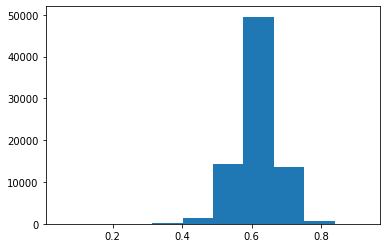

In [337]:
plt.hist(sample_exagg_preds.numpy())

In [340]:
torch.mean(abs(sample_exagg_preds - eq_preds))

tensor(0.0119)

#### Medium

In [341]:
q_los = [X_train_sample_eq[column].quantile(q=1/4) for column in columns_horse1]
q_his = [X_train_sample_eq[column].quantile(q=3/4) for column in columns_horse1]

In [342]:
q_los

[0.075,
 0.075,
 0.075,
 0.7829666902316295,
 0.8025404403145713,
 0.8025404403145713,
 0.5445689914674867,
 0.534443696377344,
 0.54510870864489]

In [343]:
q_his

[0.2,
 0.2,
 0.2,
 0.7964694140641242,
 0.8165498035705404,
 0.8166393128202973,
 0.5895933502852463,
 0.5790988472987025,
 0.5910519907743996]

In [344]:
X_train_sample_exagg = X_train_sample_eq.copy()
X_train_sample_exagg.shape

(80067, 144)

In [345]:
for column, q_lo in zip(columns_horse1, q_los):
    X_train_sample_exagg[column] = q_lo

In [346]:
for column, q_hi in zip(columns_horse2, q_his):
    X_train_sample_exagg[column] = q_hi

In [347]:
X_train_sample_exagg_tensor = torch.from_numpy(X_train_sample_exagg.to_numpy()).float().to(device)

In [348]:
with torch.no_grad():
    sample_exagg_preds = torch.sigmoid(net.forward(X_train_sample_exagg_tensor))

In [349]:
sample_exagg_preds.numpy()

array([[0.5917357],
       [0.6651375],
       [0.5845842],
       ...,
       [0.5595881],
       [0.4596911],
       [0.698477 ]], dtype=float32)

In [350]:
torch.mean(sample_exagg_preds)

tensor(0.6147)

(array([4.0000e+00, 1.4000e+01, 4.2000e+01, 2.4200e+02, 1.5410e+03,
        1.4183e+04, 5.0340e+04, 1.2952e+04, 6.9000e+02, 5.9000e+01]),
 array([0.04924766, 0.13691893, 0.2245902 , 0.31226146, 0.39993274,
        0.48760402, 0.5752753 , 0.6629465 , 0.7506178 , 0.8382891 ,
        0.92596036], dtype=float32),
 <BarContainer object of 10 artists>)

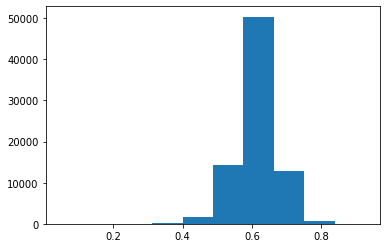

In [351]:
plt.hist(sample_exagg_preds.numpy())

In [353]:
torch.mean(abs(sample_exagg_preds - eq_preds))

tensor(0.0132)

#### High

In [354]:
q_los = [X_train_sample_eq[column].quantile(q=1/5) for column in columns_horse1]
q_his = [X_train_sample_eq[column].quantile(q=4/5) for column in columns_horse1]

In [355]:
q_los

[0.05,
 0.05,
 0.05,
 0.782023198885685,
 0.8015733621876803,
 0.8015432964524856,
 0.5410542997215436,
 0.5309146448845048,
 0.5415883794118409]

In [356]:
q_his

[0.225,
 0.225,
 0.225,
 0.7992265147419632,
 0.8194143014553776,
 0.8194241384454721,
 0.5985009864135731,
 0.5878763770258646,
 0.6002295110108569]

In [357]:
X_train_sample_exagg = X_train_sample_eq.copy()
X_train_sample_exagg.shape

(80067, 144)

In [358]:
for column, q_lo in zip(columns_horse1, q_los):
    X_train_sample_exagg[column] = q_lo

In [359]:
for column, q_hi in zip(columns_horse2, q_his):
    X_train_sample_exagg[column] = q_hi

In [360]:
X_train_sample_exagg_tensor = torch.from_numpy(X_train_sample_exagg.to_numpy()).float().to(device)

In [361]:
with torch.no_grad():
    sample_exagg_preds = torch.sigmoid(net.forward(X_train_sample_exagg_tensor))

In [362]:
sample_exagg_preds.numpy()

array([[0.5879053 ],
       [0.6616016 ],
       [0.58612806],
       ...,
       [0.5611552 ],
       [0.4612725 ],
       [0.6998153 ]], dtype=float32)

In [363]:
torch.mean(sample_exagg_preds)

tensor(0.6131)

(array([4.0000e+00, 1.4000e+01, 4.4000e+01, 2.5000e+02, 1.5890e+03,
        1.4041e+04, 5.0978e+04, 1.2431e+04, 6.5700e+02, 5.9000e+01]),
 array([0.04821862, 0.13588348, 0.22354835, 0.31121323, 0.3988781 ,
        0.48654297, 0.57420784, 0.66187274, 0.7495376 , 0.8372025 ,
        0.92486733], dtype=float32),
 <BarContainer object of 10 artists>)

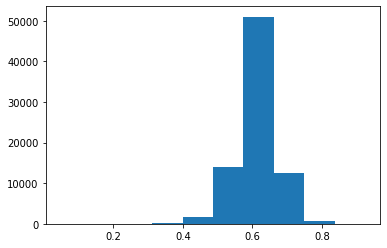

In [364]:
plt.hist(sample_exagg_preds.numpy())

In [365]:
torch.mean(abs(sample_exagg_preds - eq_preds))

tensor(0.0148)

### Coures Races

In [366]:
columns_horse1 = [
    'horse1_jockey_prev_1_position_course',
    'horse1_jockey_prev_2_position_course',
    'horse1_jockey_prev_3_position_course',
    'horse1_jockey_prev_1_finishing_time_ratio_course',
    'horse1_jockey_prev_2_finishing_time_ratio_course',
    'horse1_jockey_prev_3_finishing_time_ratio_course',
]

In [367]:
columns_horse2 = [
    'horse2_jockey_prev_1_position_course',
    'horse2_jockey_prev_2_position_course',
    'horse2_jockey_prev_3_position_course',
    'horse2_jockey_prev_1_finishing_time_ratio_course',
    'horse2_jockey_prev_2_finishing_time_ratio_course',
    'horse2_jockey_prev_3_finishing_time_ratio_course',
]

#### Small

In [368]:
q_los = [X_train_sample_eq[column].quantile(q=1/3) for column in columns_horse1]
q_his = [X_train_sample_eq[column].quantile(q=2/3) for column in columns_horse1]

In [369]:
q_los

[0.1, 0.1, 0.1, 0.7845904579745484, 0.7845817418561325, 0.7845352574964265]

In [370]:
q_his

[0.175,
 0.175,
 0.175,
 0.7928639747161806,
 0.7929228871238266,
 0.7928639747161806]

In [371]:
X_train_sample_exagg = X_train_sample_eq.copy()
X_train_sample_exagg.shape

(80067, 144)

In [372]:
for column, q_lo in zip(columns_horse1, q_los):
    X_train_sample_exagg[column] = q_lo

In [373]:
for column, q_hi in zip(columns_horse2, q_his):
    X_train_sample_exagg[column] = q_hi

In [374]:
X_train_sample_exagg_tensor = torch.from_numpy(X_train_sample_exagg.to_numpy()).float().to(device)

In [375]:
with torch.no_grad():
    sample_exagg_preds = torch.sigmoid(net.forward(X_train_sample_exagg_tensor))

In [376]:
sample_exagg_preds.numpy()

array([[0.61812335],
       [0.6827073 ],
       [0.5637313 ],
       ...,
       [0.55891705],
       [0.47107312],
       [0.6637646 ]], dtype=float32)

In [377]:
torch.mean(sample_exagg_preds)

tensor(0.6194)

(array([5.0000e+00, 9.0000e+00, 3.5000e+01, 1.5600e+02, 8.9400e+02,
        6.8730e+03, 3.9127e+04, 3.0141e+04, 2.6590e+03, 1.6800e+02]),
 array([0.05363256, 0.13648358, 0.2193346 , 0.30218562, 0.38503665,
        0.46788767, 0.5507387 , 0.63358974, 0.71644074, 0.7992918 ,
        0.8821428 ], dtype=float32),
 <BarContainer object of 10 artists>)

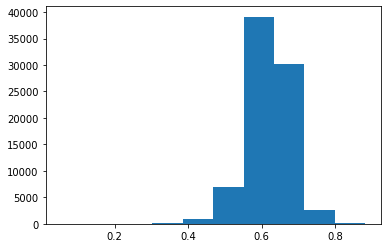

In [378]:
plt.hist(sample_exagg_preds.numpy())

In [379]:
torch.mean(abs(sample_exagg_preds - eq_preds))

tensor(0.0090)

#### Medium

In [380]:
q_los = [X_train_sample_eq[column].quantile(q=1/4) for column in columns_horse1]
q_his = [X_train_sample_eq[column].quantile(q=3/4) for column in columns_horse1]

In [381]:
q_los

[0.075,
 0.075,
 0.075,
 0.7829666902316295,
 0.7829666902316295,
 0.7829666902316295]

In [382]:
q_his

[0.2, 0.2, 0.2, 0.7963504826069203, 0.7963987191749489, 0.7963987191749489]

In [383]:
X_train_sample_exagg = X_train_sample_eq.copy()
X_train_sample_exagg.shape

(80067, 144)

In [384]:
for column, q_lo in zip(columns_horse1, q_los):
    X_train_sample_exagg[column] = q_lo

In [385]:
for column, q_hi in zip(columns_horse2, q_his):
    X_train_sample_exagg[column] = q_hi

In [386]:
X_train_sample_exagg_tensor = torch.from_numpy(X_train_sample_exagg.to_numpy()).float().to(device)

In [387]:
with torch.no_grad():
    sample_exagg_preds = torch.sigmoid(net.forward(X_train_sample_exagg_tensor))

In [388]:
sample_exagg_preds.numpy()

array([[0.6214392 ],
       [0.6857478 ],
       [0.5626565 ],
       ...,
       [0.55784005],
       [0.46998546],
       [0.66278917]], dtype=float32)

In [389]:
torch.mean(sample_exagg_preds)

tensor(0.6210)

(array([5.0000e+00, 9.0000e+00, 3.3000e+01, 1.5100e+02, 8.9200e+02,
        7.0920e+03, 3.8446e+04, 3.0449e+04, 2.8140e+03, 1.7600e+02]),
 array([0.05457621, 0.13747838, 0.22038056, 0.30328274, 0.3861849 ,
        0.46908706, 0.55198926, 0.6348914 , 0.7177936 , 0.8006957 ,
        0.8835979 ], dtype=float32),
 <BarContainer object of 10 artists>)

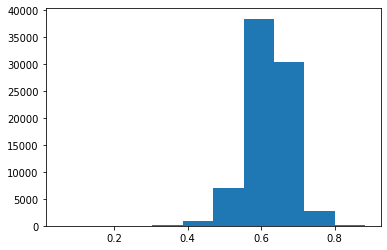

In [390]:
plt.hist(sample_exagg_preds.numpy())

In [391]:
torch.mean(abs(sample_exagg_preds - eq_preds))

tensor(0.0099)

#### High

In [392]:
q_los = [X_train_sample_eq[column].quantile(q=1/5) for column in columns_horse1]
q_his = [X_train_sample_eq[column].quantile(q=4/5) for column in columns_horse1]

In [393]:
q_los

[0.05, 0.05, 0.05, 0.782023198885685, 0.7819935590132026, 0.7819938664458573]

In [394]:
q_his

[0.225,
 0.225,
 0.225,
 0.7989938674839251,
 0.7991086899266711,
 0.7990491055143748]

In [395]:
X_train_sample_exagg = X_train_sample_eq.copy()
X_train_sample_exagg.shape

(80067, 144)

In [396]:
for column, q_lo in zip(columns_horse1, q_los):
    X_train_sample_exagg[column] = q_lo

In [397]:
for column, q_hi in zip(columns_horse2, q_his):
    X_train_sample_exagg[column] = q_hi

In [398]:
X_train_sample_exagg_tensor = torch.from_numpy(X_train_sample_exagg.to_numpy()).float().to(device)

In [399]:
with torch.no_grad():
    sample_exagg_preds = torch.sigmoid(net.forward(X_train_sample_exagg_tensor))

In [400]:
sample_exagg_preds.numpy()

array([[0.6249708 ],
       [0.6889796 ],
       [0.5616324 ],
       ...,
       [0.55681264],
       [0.46894833],
       [0.6618579 ]], dtype=float32)

In [401]:
torch.mean(sample_exagg_preds)

tensor(0.6229)

(array([5.0000e+00, 9.0000e+00, 2.9000e+01, 1.5100e+02, 8.8300e+02,
        7.2740e+03, 3.7777e+04, 3.0783e+04, 2.9760e+03, 1.8000e+02]),
 array([0.05557556, 0.13853163, 0.22148769, 0.30444375, 0.38739982,
        0.47035587, 0.55331194, 0.636268  , 0.71922404, 0.8021801 ,
        0.8851362 ], dtype=float32),
 <BarContainer object of 10 artists>)

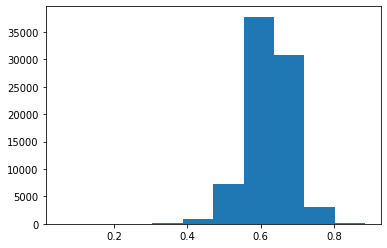

In [402]:
plt.hist(sample_exagg_preds.numpy())

In [403]:
torch.mean(abs(sample_exagg_preds - eq_preds))

tensor(0.0113)

### Metric Races

In [404]:
columns_horse1 = [
    'horse1_jockey_prev_1_position_metric',
    'horse1_jockey_prev_2_position_month',
    'horse1_jockey_prev_3_position_metric',
    'horse1_jockey_prev_1_finishing_time_ratio_metric',
    'horse1_jockey_prev_2_finishing_time_ratio_metric',
    'horse1_jockey_prev_3_finishing_time_ratio_metric',
]

In [405]:
columns_horse2 = [
    'horse2_jockey_prev_1_position_metric',
    'horse2_jockey_prev_2_position_month',
    'horse2_jockey_prev_3_position_metric',
    'horse2_jockey_prev_1_finishing_time_ratio_metric',
    'horse2_jockey_prev_2_finishing_time_ratio_metric',
    'horse2_jockey_prev_3_finishing_time_ratio_metric',
]

#### Small

In [406]:
q_los = [X_train_sample_eq[column].quantile(q=1/3) for column in columns_horse1]
q_his = [X_train_sample_eq[column].quantile(q=2/3) for column in columns_horse1]

In [407]:
q_los

[0.1, 0.1, 0.1, 0.7846141171896565, 0.7845904579745486, 0.7845926726826628]

In [408]:
q_his

[0.175,
 0.175,
 0.175,
 0.7930053644945313,
 0.7930532104830617,
 0.7930053644945313]

In [409]:
X_train_sample_exagg = X_train_sample_eq.copy()
X_train_sample_exagg.shape

(80067, 144)

In [410]:
for column, q_lo in zip(columns_horse1, q_los):
    X_train_sample_exagg[column] = q_lo

In [411]:
for column, q_hi in zip(columns_horse2, q_his):
    X_train_sample_exagg[column] = q_hi

In [412]:
X_train_sample_exagg_tensor = torch.from_numpy(X_train_sample_exagg.to_numpy()).float().to(device)

In [413]:
with torch.no_grad():
    sample_exagg_preds = torch.sigmoid(net.forward(X_train_sample_exagg_tensor))

In [414]:
sample_exagg_preds.numpy()

array([[0.6073037 ],
       [0.67583764],
       [0.5602708 ],
       ...,
       [0.55817205],
       [0.4678315 ],
       [0.66973215]], dtype=float32)

In [415]:
torch.mean(sample_exagg_preds)

tensor(0.6160)

(array([2.0000e+00, 1.2000e+01, 4.3000e+01, 1.4600e+02, 1.0630e+03,
        9.3820e+03, 4.4942e+04, 2.3102e+04, 1.3200e+03, 5.5000e+01]),
 array([0.05103752, 0.13572598, 0.22041442, 0.30510285, 0.3897913 ,
        0.47447976, 0.5591682 , 0.64385664, 0.72854507, 0.81323355,
        0.897922  ], dtype=float32),
 <BarContainer object of 10 artists>)

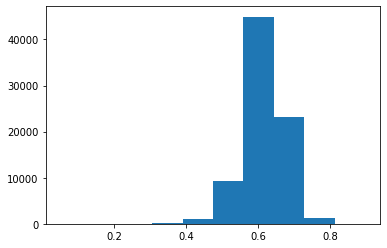

In [416]:
plt.hist(sample_exagg_preds.numpy())

In [417]:
torch.mean(abs(sample_exagg_preds - eq_preds))

tensor(0.0112)

#### Medium

In [418]:
q_los = [X_train_sample_eq[column].quantile(q=1/4) for column in columns_horse1]
q_his = [X_train_sample_eq[column].quantile(q=3/4) for column in columns_horse1]

In [419]:
q_los

[0.075,
 0.075,
 0.075,
 0.7829666902316295,
 0.7829666902316295,
 0.7829666902316295]

In [420]:
q_his

[0.2, 0.2, 0.2, 0.79652108416336, 0.79652108416336, 0.7966343688055333]

In [421]:
X_train_sample_exagg = X_train_sample_eq.copy()
X_train_sample_exagg.shape

(80067, 144)

In [422]:
for column, q_lo in zip(columns_horse1, q_los):
    X_train_sample_exagg[column] = q_lo

In [423]:
for column, q_hi in zip(columns_horse2, q_his):
    X_train_sample_exagg[column] = q_hi

In [424]:
X_train_sample_exagg_tensor = torch.from_numpy(X_train_sample_exagg.to_numpy()).float().to(device)

In [425]:
with torch.no_grad():
    sample_exagg_preds = torch.sigmoid(net.forward(X_train_sample_exagg_tensor))

In [426]:
sample_exagg_preds.numpy()

array([[0.60663074],
       [0.67521954],
       [0.5572546 ],
       ...,
       [0.5551525 ],
       [0.4647863 ],
       [0.66701996]], dtype=float32)

In [427]:
torch.mean(sample_exagg_preds)

tensor(0.6147)

(array([2.0000e+00, 1.3000e+01, 4.3000e+01, 1.5100e+02, 1.0880e+03,
        1.0108e+04, 4.5000e+04, 2.2341e+04, 1.2660e+03, 5.5000e+01]),
 array([0.05149554, 0.13617976, 0.22086397, 0.3055482 , 0.39023238,
        0.4749166 , 0.55960083, 0.644285  , 0.7289692 , 0.81365347,
        0.89833766], dtype=float32),
 <BarContainer object of 10 artists>)

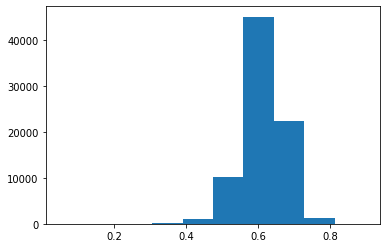

In [428]:
plt.hist(sample_exagg_preds.numpy())

In [429]:
torch.mean(abs(sample_exagg_preds - eq_preds))

tensor(0.0120)

#### High

In [430]:
q_los = [X_train_sample_eq[column].quantile(q=1/5) for column in columns_horse1]
q_his = [X_train_sample_eq[column].quantile(q=4/5) for column in columns_horse1]

In [431]:
q_los

[0.05, 0.05, 0.05, 0.7819938664458573, 0.7819934821550388, 0.782023198885685]

In [432]:
q_his

[0.225,
 0.225,
 0.225,
 0.7992265147419632,
 0.799245307054276,
 0.7995130443798147]

In [433]:
X_train_sample_exagg = X_train_sample_eq.copy()
X_train_sample_exagg.shape

(80067, 144)

In [434]:
for column, q_lo in zip(columns_horse1, q_los):
    X_train_sample_exagg[column] = q_lo

In [435]:
for column, q_hi in zip(columns_horse2, q_his):
    X_train_sample_exagg[column] = q_hi

In [436]:
X_train_sample_exagg_tensor = torch.from_numpy(X_train_sample_exagg.to_numpy()).float().to(device)

In [437]:
with torch.no_grad():
    sample_exagg_preds = torch.sigmoid(net.forward(X_train_sample_exagg_tensor))

In [438]:
sample_exagg_preds.numpy()

array([[0.60634327],
       [0.6749552 ],
       [0.55442995],
       ...,
       [0.55232465],
       [0.46194118],
       [0.6644735 ]], dtype=float32)

In [439]:
torch.mean(sample_exagg_preds)

tensor(0.6137)

(array([2.0000e+00, 1.3000e+01, 4.5000e+01, 1.5600e+02, 1.1170e+03,
        1.0804e+04, 4.4884e+04, 2.1767e+04, 1.2240e+03, 5.5000e+01]),
 array([0.05199786, 0.13668594, 0.22137402, 0.3060621 , 0.39075017,
        0.47543824, 0.5601263 , 0.64481443, 0.7295025 , 0.81419057,
        0.89887863], dtype=float32),
 <BarContainer object of 10 artists>)

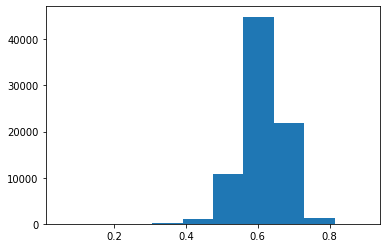

In [440]:
plt.hist(sample_exagg_preds.numpy())

In [442]:
torch.mean(abs(sample_exagg_preds - eq_preds))

tensor(0.0130)

### Track Condition Races

In [443]:
columns_horse1 = [
    'horse1_jockey_prev_1_position_ncond',
    'horse1_jockey_prev_2_position_ncond',
    'horse1_jockey_prev_3_position_ncond',
    'horse1_jockey_prev_1_finishing_time_ratio_ncond',
    'horse1_jockey_prev_2_finishing_time_ratio_ncond',
    'horse1_jockey_prev_3_finishing_time_ratio_ncond',
]

In [444]:
columns_horse2 = [
    'horse2_jockey_prev_1_position_ncond',
    'horse2_jockey_prev_2_position_ncond',
    'horse2_jockey_prev_3_position_ncond',
    'horse2_jockey_prev_1_finishing_time_ratio_ncond',
    'horse2_jockey_prev_2_finishing_time_ratio_ncond',
    'horse2_jockey_prev_3_finishing_time_ratio_ncond',
]

#### Small

In [445]:
q_los = [X_train_sample_eq[column].quantile(q=1/3) for column in columns_horse1]
q_his = [X_train_sample_eq[column].quantile(q=2/3) for column in columns_horse1]

In [446]:
q_los

[0.1, 0.1, 0.1, 0.7845352574964265, 0.7845904579745484, 0.7845904579745486]

In [447]:
q_his

[0.175,
 0.175,
 0.175,
 0.7928639747161806,
 0.7928639747161806,
 0.7929228871238266]

In [448]:
X_train_sample_exagg = X_train_sample_eq.copy()
X_train_sample_exagg.shape

(80067, 144)

In [449]:
for column, q_lo in zip(columns_horse1, q_los):
    X_train_sample_exagg[column] = q_lo

In [450]:
for column, q_hi in zip(columns_horse2, q_his):
    X_train_sample_exagg[column] = q_hi

In [451]:
X_train_sample_exagg_tensor = torch.from_numpy(X_train_sample_exagg.to_numpy()).float().to(device)

In [452]:
with torch.no_grad():
    sample_exagg_preds = torch.sigmoid(net.forward(X_train_sample_exagg_tensor))

In [453]:
sample_exagg_preds.numpy()

array([[0.6216782 ],
       [0.67370296],
       [0.5625493 ],
       ...,
       [0.56167793],
       [0.47497126],
       [0.67635596]], dtype=float32)

In [454]:
torch.mean(sample_exagg_preds)

tensor(0.6171)

(array([4.0000e+00, 1.2000e+01, 5.4000e+01, 2.4800e+02, 1.6130e+03,
        1.3018e+04, 4.7305e+04, 1.6847e+04, 8.8900e+02, 7.7000e+01]),
 array([0.05050651, 0.13741523, 0.22432396, 0.3112327 , 0.3981414 ,
        0.48505014, 0.57195884, 0.6588676 , 0.7457763 , 0.83268505,
        0.91959375], dtype=float32),
 <BarContainer object of 10 artists>)

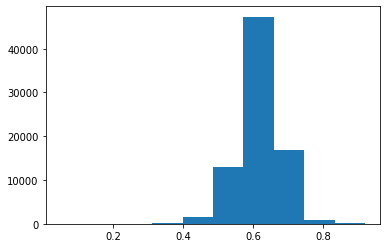

In [455]:
plt.hist(sample_exagg_preds.numpy())

In [456]:
torch.mean(abs(sample_exagg_preds - eq_preds))

tensor(0.0082)

#### Medium

In [457]:
q_los = [X_train_sample_eq[column].quantile(q=1/4) for column in columns_horse1]
q_his = [X_train_sample_eq[column].quantile(q=3/4) for column in columns_horse1]

In [458]:
q_los

[0.075,
 0.075,
 0.075,
 0.7829666902316295,
 0.7829666902316295,
 0.7829666902316295]

In [459]:
q_his

[0.2, 0.2, 0.2, 0.7962219819520104, 0.7963504826069203, 0.7964612934677049]

In [460]:
X_train_sample_exagg = X_train_sample_eq.copy()
X_train_sample_exagg.shape

(80067, 144)

In [461]:
for column, q_lo in zip(columns_horse1, q_los):
    X_train_sample_exagg[column] = q_lo

In [462]:
for column, q_hi in zip(columns_horse2, q_his):
    X_train_sample_exagg[column] = q_hi

In [463]:
X_train_sample_exagg_tensor = torch.from_numpy(X_train_sample_exagg.to_numpy()).float().to(device)

In [464]:
with torch.no_grad():
    sample_exagg_preds = torch.sigmoid(net.forward(X_train_sample_exagg_tensor))

In [465]:
sample_exagg_preds.numpy()

array([[0.6219525 ],
       [0.67395943],
       [0.56258667],
       ...,
       [0.56171435],
       [0.4750085 ],
       [0.6763882 ]], dtype=float32)

In [466]:
torch.mean(sample_exagg_preds)

tensor(0.6169)

(array([4.0000e+00, 1.2000e+01, 5.7000e+01, 2.5600e+02, 1.6780e+03,
        1.3092e+04, 4.7187e+04, 1.6814e+04, 8.9000e+02, 7.7000e+01]),
 array([0.05055534, 0.1374678 , 0.22438027, 0.31129274, 0.3982052 ,
        0.48511767, 0.5720301 , 0.6589426 , 0.7458551 , 0.83276755,
        0.91968   ], dtype=float32),
 <BarContainer object of 10 artists>)

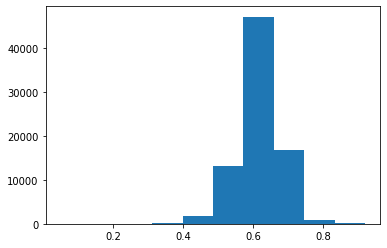

In [467]:
plt.hist(sample_exagg_preds.numpy())

In [468]:
torch.mean(abs(sample_exagg_preds - eq_preds))

tensor(0.0083)

#### High

In [469]:
q_los = [X_train_sample_eq[column].quantile(q=1/5) for column in columns_horse1]
q_his = [X_train_sample_eq[column].quantile(q=4/5) for column in columns_horse1]

In [470]:
q_los

[0.05, 0.05, 0.05, 0.7819938664458573, 0.7819934821550388, 0.7819934821550388]

In [471]:
q_his

[0.225,
 0.225,
 0.225,
 0.798943735185262,
 0.7989938674839251,
 0.7991816932682196]

In [472]:
X_train_sample_exagg = X_train_sample_eq.copy()
X_train_sample_exagg.shape

(80067, 144)

In [473]:
for column, q_lo in zip(columns_horse1, q_los):
    X_train_sample_exagg[column] = q_lo

In [474]:
for column, q_hi in zip(columns_horse2, q_his):
    X_train_sample_exagg[column] = q_hi

In [475]:
X_train_sample_exagg_tensor = torch.from_numpy(X_train_sample_exagg.to_numpy()).float().to(device)

In [476]:
with torch.no_grad():
    sample_exagg_preds = torch.sigmoid(net.forward(X_train_sample_exagg_tensor))

In [477]:
sample_exagg_preds.numpy()

array([[0.62216914],
       [0.6741621 ],
       [0.5626227 ],
       ...,
       [0.5617511 ],
       [0.47504538],
       [0.6764206 ]], dtype=float32)

In [478]:
torch.mean(sample_exagg_preds)

tensor(0.6167)

(array([4.0000e+00, 1.2000e+01, 5.8000e+01, 2.6800e+02, 1.7150e+03,
        1.3211e+04, 4.7049e+04, 1.6789e+04, 8.8400e+02, 7.7000e+01]),
 array([0.05059243, 0.13750799, 0.22442356, 0.3113391 , 0.3982547 ,
        0.48517025, 0.5720858 , 0.65900135, 0.74591696, 0.8328325 ,
        0.91974807], dtype=float32),
 <BarContainer object of 10 artists>)

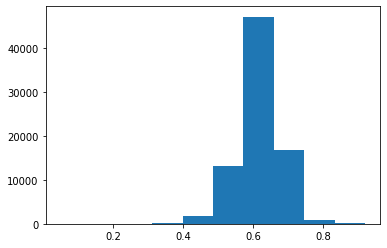

In [479]:
plt.hist(sample_exagg_preds.numpy())

In [480]:
torch.mean(abs(sample_exagg_preds - eq_preds))

tensor(0.0084)

### Runners

In [481]:
columns_horse1 = [
    'horse1_jockey_prev_1_position_runners',
    'horse1_jockey_prev_2_position_runners',
    'horse1_jockey_prev_3_position_runners',
    'horse1_jockey_prev_1_finishing_time_ratio_runners',
    'horse1_jockey_prev_2_finishing_time_ratio_runners',
    'horse1_jockey_prev_3_finishing_time_ratio_runners',
]

In [482]:
columns_horse2 = [
    'horse2_jockey_prev_1_position_runners',
    'horse2_jockey_prev_2_position_runners',
    'horse2_jockey_prev_3_position_runners',
    'horse2_jockey_prev_1_finishing_time_ratio_runners',
    'horse2_jockey_prev_2_finishing_time_ratio_runners',
    'horse2_jockey_prev_3_finishing_time_ratio_runners',
]

#### Small

In [483]:
q_los = [X_train_sample_eq[column].quantile(q=1/3) for column in columns_horse1]
q_his = [X_train_sample_eq[column].quantile(q=2/3) for column in columns_horse1]

In [484]:
q_los

[0.1, 0.1, 0.1, 0.8044131405454777, 0.8043943293389128, 0.7847753633906748]

In [485]:
q_his

[0.2, 0.2, 0.2, 0.8132654348901037, 0.8131682331294443, 0.7934621622399722]

In [486]:
X_train_sample_exagg = X_train_sample_eq.copy()
X_train_sample_exagg.shape

(80067, 144)

In [487]:
for column, q_lo in zip(columns_horse1, q_los):
    X_train_sample_exagg[column] = q_lo

In [488]:
for column, q_hi in zip(columns_horse2, q_his):
    X_train_sample_exagg[column] = q_hi

In [489]:
X_train_sample_exagg_tensor = torch.from_numpy(X_train_sample_exagg.to_numpy()).float().to(device)

In [490]:
with torch.no_grad():
    sample_exagg_preds = torch.sigmoid(net.forward(X_train_sample_exagg_tensor))

In [491]:
sample_exagg_preds.numpy()

array([[0.62383914],
       [0.68769956],
       [0.55508125],
       ...,
       [0.57050204],
       [0.578403  ],
       [0.6592971 ]], dtype=float32)

In [492]:
torch.mean(sample_exagg_preds)

tensor(0.6213)

(array([3.0000e+00, 1.3000e+01, 2.7000e+01, 7.4000e+01, 7.6100e+02,
        7.9580e+03, 4.4110e+04, 2.5322e+04, 1.6670e+03, 1.3200e+02]),
 array([0.05463387, 0.13873634, 0.22283882, 0.3069413 , 0.39104375,
        0.47514623, 0.5592487 , 0.6433512 , 0.72745365, 0.81155616,
        0.8956586 ], dtype=float32),
 <BarContainer object of 10 artists>)

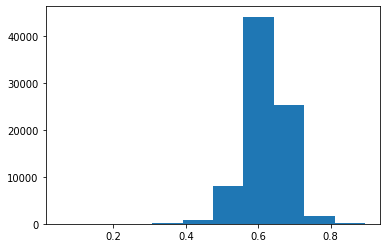

In [493]:
plt.hist(sample_exagg_preds.numpy())

In [494]:
torch.mean(abs(sample_exagg_preds - eq_preds))

tensor(0.0152)

#### Medium

In [495]:
q_los = [X_train_sample_eq[column].quantile(q=1/4) for column in columns_horse1]
q_his = [X_train_sample_eq[column].quantile(q=3/4) for column in columns_horse1]

In [496]:
q_los

[0.075,
 0.075,
 0.075,
 0.8027634010029951,
 0.8026853647620468,
 0.7831080800099801]

In [497]:
q_his

[0.225,
 0.225,
 0.225,
 0.8168879606146501,
 0.8168879606146501,
 0.7970397486714913]

In [498]:
X_train_sample_exagg = X_train_sample_eq.copy()
X_train_sample_exagg.shape

(80067, 144)

In [499]:
for column, q_lo in zip(columns_horse1, q_los):
    X_train_sample_exagg[column] = q_lo

In [500]:
for column, q_hi in zip(columns_horse2, q_his):
    X_train_sample_exagg[column] = q_hi

In [501]:
X_train_sample_exagg_tensor = torch.from_numpy(X_train_sample_exagg.to_numpy()).float().to(device)

In [502]:
with torch.no_grad():
    sample_exagg_preds = torch.sigmoid(net.forward(X_train_sample_exagg_tensor))

In [503]:
sample_exagg_preds.numpy()

array([[0.6265868 ],
       [0.6902128 ],
       [0.55221534],
       ...,
       [0.56765777],
       [0.5755719 ],
       [0.65668684]], dtype=float32)

In [504]:
torch.mean(sample_exagg_preds)

tensor(0.6224)

(array([3.0000e+00, 1.3000e+01, 2.6000e+01, 7.9000e+01, 7.0400e+02,
        8.6020e+03, 4.3021e+04, 2.5707e+04, 1.7770e+03, 1.3500e+02]),
 array([0.05585134, 0.13994117, 0.224031  , 0.30812085, 0.39221066,
        0.4763005 , 0.56039035, 0.64448017, 0.72857   , 0.81265986,
        0.8967497 ], dtype=float32),
 <BarContainer object of 10 artists>)

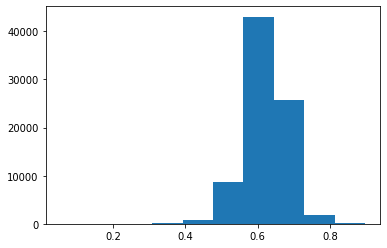

In [505]:
plt.hist(sample_exagg_preds.numpy())

In [506]:
torch.mean(abs(sample_exagg_preds - eq_preds))

tensor(0.0161)

#### High

In [507]:
q_los = [X_train_sample_eq[column].quantile(q=1/5) for column in columns_horse1]
q_his = [X_train_sample_eq[column].quantile(q=4/5) for column in columns_horse1]

In [508]:
q_los

[0.075, 0.075, 0.075, 0.8017554328907454, 0.801754557017755, 0.782199974421551]

In [509]:
q_his

[0.25, 0.25, 0.25, 0.8196213060580584, 0.8199207540573593, 0.7999211612291369]

In [510]:
X_train_sample_exagg = X_train_sample_eq.copy()
X_train_sample_exagg.shape

(80067, 144)

In [511]:
for column, q_lo in zip(columns_horse1, q_los):
    X_train_sample_exagg[column] = q_lo

In [512]:
for column, q_hi in zip(columns_horse2, q_his):
    X_train_sample_exagg[column] = q_hi

In [513]:
X_train_sample_exagg_tensor = torch.from_numpy(X_train_sample_exagg.to_numpy()).float().to(device)

In [514]:
with torch.no_grad():
    sample_exagg_preds = torch.sigmoid(net.forward(X_train_sample_exagg_tensor))

In [515]:
sample_exagg_preds.numpy()

array([[0.62533   ],
       [0.68906343],
       [0.54872733],
       ...,
       [0.5641949 ],
       [0.5721249 ],
       [0.6535017 ]], dtype=float32)

In [516]:
torch.mean(sample_exagg_preds)

tensor(0.6204)

(array([3.0000e+00, 1.3000e+01, 2.7000e+01, 8.0000e+01, 7.3800e+02,
        9.3280e+03, 4.3079e+04, 2.4953e+04, 1.7130e+03, 1.3300e+02]),
 array([0.05631335, 0.14030717, 0.224301  , 0.30829483, 0.39228866,
        0.47628248, 0.5602763 , 0.6442701 , 0.728264  , 0.81225777,
        0.8962516 ], dtype=float32),
 <BarContainer object of 10 artists>)

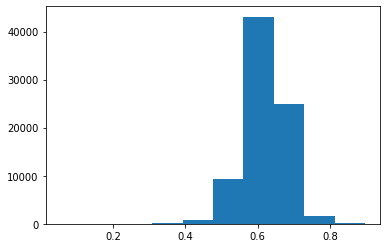

In [517]:
plt.hist(sample_exagg_preds.numpy())

In [519]:
torch.mean(abs(sample_exagg_preds - eq_preds))

tensor(0.0165)

### Month Races

In [520]:
columns_horse1 = [
    'horse1_jockey_prev_1_position_month',
    'horse1_jockey_prev_2_position_month',
    'horse1_jockey_prev_3_position_month',
    'horse1_jockey_prev_1_finishing_time_ratio_month',
    'horse1_jockey_prev_2_finishing_time_ratio_month',
    'horse1_jockey_prev_3_finishing_time_ratio_month',
]

In [521]:
columns_horse2 = [
    'horse2_jockey_prev_1_position_month',
    'horse2_jockey_prev_2_position_month',
    'horse2_jockey_prev_3_position_month',
    'horse2_jockey_prev_1_finishing_time_ratio_month',
    'horse2_jockey_prev_2_finishing_time_ratio_month',
    'horse2_jockey_prev_3_finishing_time_ratio_month',
]

#### Small

In [522]:
q_los = [X_train_sample_eq[column].quantile(q=1/3) for column in columns_horse1]
q_his = [X_train_sample_eq[column].quantile(q=2/3) for column in columns_horse1]

In [523]:
q_los

[0.1, 0.1, 0.1, 0.7846141171896565, 0.7846208144331395, 0.8042290520687826]

In [524]:
q_his

[0.175,
 0.175,
 0.175,
 0.7930934861844718,
 0.7931210070975826,
 0.8130474627565484]

In [525]:
X_train_sample_exagg = X_train_sample_eq.copy()
X_train_sample_exagg.shape

(80067, 144)

In [526]:
for column, q_lo in zip(columns_horse1, q_los):
    X_train_sample_exagg[column] = q_lo

In [527]:
for column, q_hi in zip(columns_horse2, q_his):
    X_train_sample_exagg[column] = q_hi

In [528]:
X_train_sample_exagg_tensor = torch.from_numpy(X_train_sample_exagg.to_numpy()).float().to(device)

In [529]:
with torch.no_grad():
    sample_exagg_preds = torch.sigmoid(net.forward(X_train_sample_exagg_tensor))

In [530]:
sample_exagg_preds.numpy()

array([[0.61242455],
       [0.6594578 ],
       [0.55008614],
       ...,
       [0.56222796],
       [0.4755333 ],
       [0.6485015 ]], dtype=float32)

In [531]:
torch.mean(sample_exagg_preds)

tensor(0.6082)

(array([4.0000e+00, 1.1000e+01, 6.0000e+01, 1.9800e+02, 1.1380e+03,
        7.3020e+03, 3.8530e+04, 3.0256e+04, 2.4720e+03, 9.6000e+01]),
 array([0.04965964, 0.13169828, 0.2137369 , 0.29577556, 0.3778142 ,
        0.4598528 , 0.54189146, 0.6239301 , 0.70596874, 0.7880074 ,
        0.870046  ], dtype=float32),
 <BarContainer object of 10 artists>)

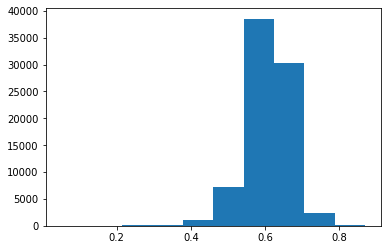

In [532]:
plt.hist(sample_exagg_preds.numpy())

In [533]:
torch.mean(abs(sample_exagg_preds - eq_preds))

tensor(0.0156)

#### Medium

In [534]:
q_los = [X_train_sample_eq[column].quantile(q=1/4) for column in columns_horse1]
q_his = [X_train_sample_eq[column].quantile(q=3/4) for column in columns_horse1]

In [535]:
q_los

[0.075,
 0.075,
 0.075,
 0.7829666902316295,
 0.7829927883831421,
 0.8025404403145713]

In [536]:
q_his

[0.2, 0.2, 0.2, 0.7964694140641242, 0.7966756331208951, 0.8167505120709286]

In [537]:
X_train_sample_exagg = X_train_sample_eq.copy()
X_train_sample_exagg.shape

(80067, 144)

In [538]:
for column, q_lo in zip(columns_horse1, q_los):
    X_train_sample_exagg[column] = q_lo

In [539]:
for column, q_hi in zip(columns_horse2, q_his):
    X_train_sample_exagg[column] = q_hi

In [540]:
X_train_sample_exagg_tensor = torch.from_numpy(X_train_sample_exagg.to_numpy()).float().to(device)

In [541]:
with torch.no_grad():
    sample_exagg_preds = torch.sigmoid(net.forward(X_train_sample_exagg_tensor))

In [542]:
sample_exagg_preds.numpy()

array([[0.6074074 ],
       [0.65470624],
       [0.54653674],
       ...,
       [0.55869687],
       [0.47195917],
       [0.645227  ]], dtype=float32)

In [543]:
torch.mean(sample_exagg_preds)

tensor(0.6040)

(array([4.0000e+00, 1.2000e+01, 6.2000e+01, 2.0800e+02, 1.1970e+03,
        7.7020e+03, 3.9669e+04, 2.8838e+04, 2.2870e+03, 8.8000e+01]),
 array([0.04934194, 0.13117206, 0.21300218, 0.2948323 , 0.3766624 ,
        0.45849252, 0.54032266, 0.62215275, 0.7039829 , 0.785813  ,
        0.8676431 ], dtype=float32),
 <BarContainer object of 10 artists>)

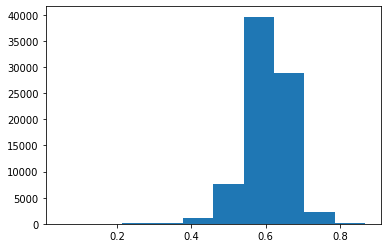

In [544]:
plt.hist(sample_exagg_preds.numpy())

In [545]:
torch.mean(abs(sample_exagg_preds - eq_preds))

tensor(0.0179)

#### High

In [546]:
q_los = [X_train_sample_eq[column].quantile(q=1/5) for column in columns_horse1]
q_his = [X_train_sample_eq[column].quantile(q=4/5) for column in columns_horse1]

In [547]:
q_los

[0.05, 0.05, 0.05, 0.782023198885685, 0.782023198885685, 0.8015733621876803]

In [548]:
q_his

[0.225,
 0.225,
 0.225,
 0.7992265147419635,
 0.7994385994094895,
 0.8195411928068946]

In [549]:
X_train_sample_exagg = X_train_sample_eq.copy()
X_train_sample_exagg.shape

(80067, 144)

In [550]:
for column, q_lo in zip(columns_horse1, q_los):
    X_train_sample_exagg[column] = q_lo

In [551]:
for column, q_hi in zip(columns_horse2, q_his):
    X_train_sample_exagg[column] = q_hi

In [552]:
X_train_sample_exagg_tensor = torch.from_numpy(X_train_sample_exagg.to_numpy()).float().to(device)

In [553]:
with torch.no_grad():
    sample_exagg_preds = torch.sigmoid(net.forward(X_train_sample_exagg_tensor))

In [554]:
sample_exagg_preds.numpy()

array([[0.60250247],
       [0.65005165],
       [0.5430299 ],
       ...,
       [0.5552072 ],
       [0.4684366 ],
       [0.6419831 ]], dtype=float32)

In [555]:
torch.mean(sample_exagg_preds)

tensor(0.6000)

(array([4.0000e+00, 1.2000e+01, 6.5000e+01, 2.1600e+02, 1.2620e+03,
        8.1320e+03, 4.0787e+04, 2.7398e+04, 2.1080e+03, 8.3000e+01]),
 array([0.04904342, 0.13066591, 0.21228841, 0.2939109 , 0.3755334 ,
        0.45715588, 0.53877836, 0.62040085, 0.7020234 , 0.78364587,
        0.86526835], dtype=float32),
 <BarContainer object of 10 artists>)

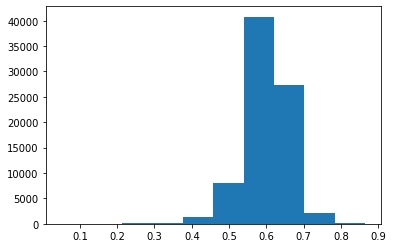

In [556]:
plt.hist(sample_exagg_preds.numpy())

In [557]:
torch.mean(abs(sample_exagg_preds - eq_preds))

tensor(0.0207)

### Temp Races

In [559]:
columns_horse1 = [
    'horse1_jockey_prev_1_position_temp',
    'horse1_jockey_prev_2_position_temp',
    'horse1_jockey_prev_3_position_temp',
    'horse1_jockey_prev_1_finishing_time_ratio_temp',
    'horse1_jockey_prev_2_finishing_time_ratio_temp',
    'horse1_jockey_prev_3_finishing_time_ratio_temp',
]

In [560]:
columns_horse2 = [
    'horse2_jockey_prev_1_position_temp',
    'horse2_jockey_prev_2_position_temp',
    'horse2_jockey_prev_3_position_temp',
    'horse2_jockey_prev_1_finishing_time_ratio_temp',
    'horse2_jockey_prev_2_finishing_time_ratio_temp',
    'horse2_jockey_prev_3_finishing_time_ratio_temp',
]

#### Small

In [561]:
q_los = [X_train_sample_eq[column].quantile(q=1/3) for column in columns_horse1]
q_his = [X_train_sample_eq[column].quantile(q=2/3) for column in columns_horse1]

In [562]:
q_los

[0.1, 0.1, 0.1, 0.784592672682663, 0.7845926726826628, 0.784592672682663]

In [563]:
q_his

[0.175,
 0.175,
 0.175,
 0.7930765461886053,
 0.7930428136790673,
 0.7930053644945313]

In [564]:
X_train_sample_exagg = X_train_sample_eq.copy()
X_train_sample_exagg.shape

(80067, 144)

In [565]:
for column, q_lo in zip(columns_horse1, q_los):
    X_train_sample_exagg[column] = q_lo

In [566]:
for column, q_hi in zip(columns_horse2, q_his):
    X_train_sample_exagg[column] = q_hi

In [567]:
X_train_sample_exagg_tensor = torch.from_numpy(X_train_sample_exagg.to_numpy()).float().to(device)

In [568]:
with torch.no_grad():
    sample_exagg_preds = torch.sigmoid(net.forward(X_train_sample_exagg_tensor))

In [569]:
sample_exagg_preds.numpy()

array([[0.64654166],
       [0.6619928 ],
       [0.59519833],
       ...,
       [0.5548017 ],
       [0.47086886],
       [0.6914359 ]], dtype=float32)

In [570]:
torch.mean(sample_exagg_preds)

tensor(0.6245)

(array([4.0000e+00, 1.0000e+01, 3.2000e+01, 1.3500e+02, 8.4100e+02,
        6.2820e+03, 4.3306e+04, 2.7344e+04, 1.9730e+03, 1.4000e+02]),
 array([0.05214136, 0.13646436, 0.22078736, 0.30511037, 0.38943335,
        0.47375637, 0.55807936, 0.64240235, 0.7267254 , 0.8110484 ,
        0.8953714 ], dtype=float32),
 <BarContainer object of 10 artists>)

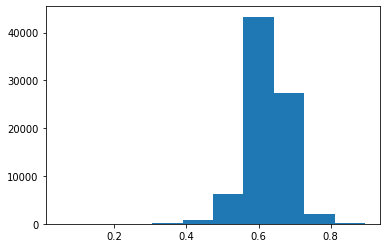

In [571]:
plt.hist(sample_exagg_preds.numpy())

In [572]:
torch.mean(abs(sample_exagg_preds - eq_preds))

tensor(0.0122)

#### Medium

In [573]:
q_los = [X_train_sample_eq[column].quantile(q=1/4) for column in columns_horse1]
q_his = [X_train_sample_eq[column].quantile(q=3/4) for column in columns_horse1]

In [574]:
q_los

[0.075,
 0.075,
 0.075,
 0.7829666902316295,
 0.7829666902316295,
 0.7829666902316295]

In [575]:
q_his

[0.2, 0.2, 0.2, 0.7964694140641242, 0.796627532720104, 0.796627532720104]

In [576]:
X_train_sample_exagg = X_train_sample_eq.copy()
X_train_sample_exagg.shape

(80067, 144)

In [577]:
for column, q_lo in zip(columns_horse1, q_los):
    X_train_sample_exagg[column] = q_lo

In [578]:
for column, q_hi in zip(columns_horse2, q_his):
    X_train_sample_exagg[column] = q_hi

In [579]:
X_train_sample_exagg_tensor = torch.from_numpy(X_train_sample_exagg.to_numpy()).float().to(device)

In [580]:
with torch.no_grad():
    sample_exagg_preds = torch.sigmoid(net.forward(X_train_sample_exagg_tensor))

In [581]:
sample_exagg_preds.numpy()

array([[0.6491838 ],
       [0.6645794 ],
       [0.6008732 ],
       ...,
       [0.56062543],
       [0.47675428],
       [0.69644994]], dtype=float32)

In [582]:
torch.mean(sample_exagg_preds)

tensor(0.6280)

(array([4.0000e+00, 1.0000e+01, 2.8000e+01, 1.3500e+02, 7.9100e+02,
        5.5890e+03, 4.2181e+04, 2.9099e+04, 2.0830e+03, 1.4700e+02]),
 array([0.05155011, 0.13604024, 0.22053036, 0.30502048, 0.3895106 ,
        0.47400072, 0.5584909 , 0.642981  , 0.7274711 , 0.81196123,
        0.89645135], dtype=float32),
 <BarContainer object of 10 artists>)

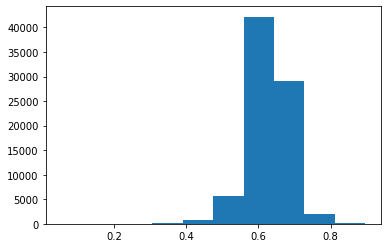

In [583]:
plt.hist(sample_exagg_preds.numpy())

In [584]:
torch.mean(abs(sample_exagg_preds - eq_preds))

tensor(0.0142)

#### High

In [585]:
q_los = [X_train_sample_eq[column].quantile(q=1/5) for column in columns_horse1]
q_his = [X_train_sample_eq[column].quantile(q=4/5) for column in columns_horse1]

In [586]:
q_los

[0.05, 0.05, 0.05, 0.782023198885685, 0.782023198885685, 0.7819938664458573]

In [587]:
q_his

[0.225,
 0.225,
 0.225,
 0.7992265147419635,
 0.7993729820537908,
 0.7994385994094895]

In [588]:
X_train_sample_exagg = X_train_sample_eq.copy()
X_train_sample_exagg.shape

(80067, 144)

In [589]:
for column, q_lo in zip(columns_horse1, q_los):
    X_train_sample_exagg[column] = q_lo

In [590]:
for column, q_hi in zip(columns_horse2, q_his):
    X_train_sample_exagg[column] = q_hi

In [591]:
X_train_sample_exagg_tensor = torch.from_numpy(X_train_sample_exagg.to_numpy()).float().to(device)

In [592]:
with torch.no_grad():
    sample_exagg_preds = torch.sigmoid(net.forward(X_train_sample_exagg_tensor))

In [593]:
sample_exagg_preds.numpy()

array([[0.6517064 ],
       [0.6670479 ],
       [0.6063426 ],
       ...,
       [0.5662481 ],
       [0.48246005],
       [0.7012605 ]], dtype=float32)

In [594]:
torch.mean(sample_exagg_preds)

tensor(0.6314)

(array([4.0000e+00, 1.0000e+01, 2.7000e+01, 1.2300e+02, 7.6100e+02,
        5.0700e+03, 4.0911e+04, 3.0813e+04, 2.1990e+03, 1.4900e+02]),
 array([0.05097797, 0.13562785, 0.22027774, 0.30492762, 0.3895775 ,
        0.47422737, 0.5588773 , 0.64352715, 0.728177  , 0.81282693,
        0.8974768 ], dtype=float32),
 <BarContainer object of 10 artists>)

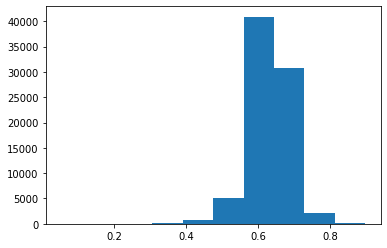

In [595]:
plt.hist(sample_exagg_preds.numpy())

In [596]:
torch.mean(abs(sample_exagg_preds - eq_preds))

tensor(0.0166)

### Pressure Races

In [598]:
columns_horse1 = [
    'horse1_jockey_prev_1_position_msl',
    'horse1_jockey_prev_2_position_msl',
    'horse1_jockey_prev_3_position_msl',
    'horse1_jockey_prev_1_finishing_time_ratio_msl',
    'horse1_jockey_prev_2_finishing_time_ratio_msl',
    'horse1_jockey_prev_3_finishing_time_ratio_msl',
]

In [599]:
columns_horse2 = [
    'horse2_jockey_prev_1_position_msl',
    'horse2_jockey_prev_2_position_msl',
    'horse2_jockey_prev_3_position_msl',
    'horse2_jockey_prev_1_finishing_time_ratio_msl',
    'horse2_jockey_prev_2_finishing_time_ratio_msl',
    'horse2_jockey_prev_3_finishing_time_ratio_msl',
]

#### Small

In [600]:
q_los = [X_train_sample_eq[column].quantile(q=1/3) for column in columns_horse1]
q_his = [X_train_sample_eq[column].quantile(q=2/3) for column in columns_horse1]

In [601]:
q_los

[0.1, 0.1, 0.1, 0.7846208144331395, 0.784592672682663, 0.784592672682663]

In [602]:
q_his

[0.175,
 0.175,
 0.175,
 0.7930284840591358,
 0.7931210070975826,
 0.7930934861844718]

In [603]:
X_train_sample_exagg = X_train_sample_eq.copy()
X_train_sample_exagg.shape

(80067, 144)

In [604]:
for column, q_lo in zip(columns_horse1, q_los):
    X_train_sample_exagg[column] = q_lo

In [605]:
for column, q_hi in zip(columns_horse2, q_his):
    X_train_sample_exagg[column] = q_hi

In [606]:
X_train_sample_exagg_tensor = torch.from_numpy(X_train_sample_exagg.to_numpy()).float().to(device)

In [607]:
with torch.no_grad():
    sample_exagg_preds = torch.sigmoid(net.forward(X_train_sample_exagg_tensor))

In [608]:
sample_exagg_preds.numpy()

array([[0.64815044],
       [0.6778773 ],
       [0.5658314 ],
       ...,
       [0.5748251 ],
       [0.48766237],
       [0.6852933 ]], dtype=float32)

In [609]:
torch.mean(sample_exagg_preds)

tensor(0.6281)

(array([5.0000e+00, 9.0000e+00, 2.6000e+01, 1.5100e+02, 8.3700e+02,
        5.6270e+03, 3.3776e+04, 3.6011e+04, 3.4810e+03, 1.4400e+02]),
 array([0.05316832, 0.13602246, 0.2188766 , 0.30173072, 0.38458487,
        0.467439  , 0.55029315, 0.6331473 , 0.7160014 , 0.79885554,
        0.8817097 ], dtype=float32),
 <BarContainer object of 10 artists>)

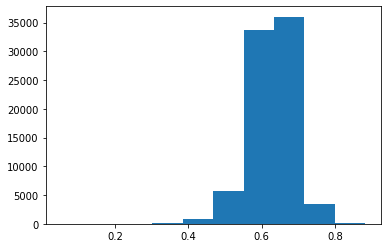

In [610]:
plt.hist(sample_exagg_preds.numpy())

In [611]:
torch.mean(abs(sample_exagg_preds - eq_preds))

tensor(0.0136)

#### Medium

In [612]:
q_los = [X_train_sample_eq[column].quantile(q=1/4) for column in columns_horse1]
q_his = [X_train_sample_eq[column].quantile(q=3/4) for column in columns_horse1]

In [613]:
q_los

[0.075,
 0.075,
 0.075,
 0.7829666902316295,
 0.7829666902316295,
 0.7829666902316295]

In [614]:
q_his

[0.2, 0.2, 0.2, 0.7965210841633598, 0.7966265565989783, 0.796627532720104]

In [615]:
X_train_sample_exagg = X_train_sample_eq.copy()
X_train_sample_exagg.shape

(80067, 144)

In [616]:
for column, q_lo in zip(columns_horse1, q_los):
    X_train_sample_exagg[column] = q_lo

In [617]:
for column, q_hi in zip(columns_horse2, q_his):
    X_train_sample_exagg[column] = q_hi

In [618]:
X_train_sample_exagg_tensor = torch.from_numpy(X_train_sample_exagg.to_numpy()).float().to(device)

In [619]:
with torch.no_grad():
    sample_exagg_preds = torch.sigmoid(net.forward(X_train_sample_exagg_tensor))

In [620]:
sample_exagg_preds.numpy()

array([[0.658789  ],
       [0.68804944],
       [0.57163566],
       ...,
       [0.5805989 ],
       [0.49357632],
       [0.69037515]], dtype=float32)

In [621]:
torch.mean(sample_exagg_preds)

tensor(0.6364)

(array([5.0000e+00, 9.0000e+00, 1.9000e+01, 1.4800e+02, 7.5200e+02,
        5.1030e+03, 3.1568e+04, 3.8046e+04, 4.2650e+03, 1.5200e+02]),
 array([0.05435438, 0.1375712 , 0.22078802, 0.30400482, 0.38722163,
        0.47043845, 0.55365527, 0.6368721 , 0.7200889 , 0.80330575,
        0.88652253], dtype=float32),
 <BarContainer object of 10 artists>)

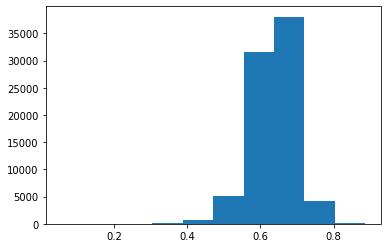

In [622]:
plt.hist(sample_exagg_preds.numpy())

In [623]:
torch.mean(abs(sample_exagg_preds - eq_preds))

tensor(0.0203)

#### High

In [624]:
q_los = [X_train_sample_eq[column].quantile(q=1/5) for column in columns_horse1]
q_his = [X_train_sample_eq[column].quantile(q=4/5) for column in columns_horse1]

In [625]:
q_los

[0.05, 0.05, 0.05, 0.7820414904769664, 0.7819938664458573, 0.7819934821550388]

In [626]:
q_his

[0.225,
 0.225,
 0.225,
 0.7992736446680804,
 0.7993964084987206,
 0.7993729820537908]

In [627]:
X_train_sample_exagg = X_train_sample_eq.copy()
X_train_sample_exagg.shape

(80067, 144)

In [628]:
for column, q_lo in zip(columns_horse1, q_los):
    X_train_sample_exagg[column] = q_lo

In [629]:
for column, q_hi in zip(columns_horse2, q_his):
    X_train_sample_exagg[column] = q_hi

In [630]:
X_train_sample_exagg_tensor = torch.from_numpy(X_train_sample_exagg.to_numpy()).float().to(device)

In [631]:
with torch.no_grad():
    sample_exagg_preds = torch.sigmoid(net.forward(X_train_sample_exagg_tensor))

In [632]:
sample_exagg_preds.numpy()

array([[0.66948533],
       [0.698249  ],
       [0.5775781 ],
       ...,
       [0.58650655],
       [0.49965382],
       [0.6955475 ]], dtype=float32)

In [633]:
torch.mean(sample_exagg_preds)

tensor(0.6448)

(array([5.0000e+00, 9.0000e+00, 1.8000e+01, 1.3200e+02, 6.6900e+02,
        4.6870e+03, 2.9455e+04, 3.9668e+04, 5.2540e+03, 1.7000e+02]),
 array([0.05558266, 0.13915022, 0.22271778, 0.30628532, 0.38985288,
        0.47342044, 0.556988  , 0.64055556, 0.7241231 , 0.8076907 ,
        0.89125824], dtype=float32),
 <BarContainer object of 10 artists>)

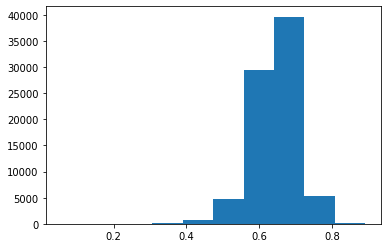

In [634]:
plt.hist(sample_exagg_preds.numpy())

In [635]:
torch.mean(abs(sample_exagg_preds - eq_preds))

tensor(0.0283)

### Rain Races

In [637]:
columns_horse1 = [
    'horse1_jockey_prev_1_position_rain',
    'horse1_jockey_prev_2_position_rain',
    'horse1_jockey_prev_3_position_rain',
    'horse1_jockey_prev_1_finishing_time_ratio_rain',
    'horse1_jockey_prev_2_finishing_time_ratio_rain',
    'horse1_jockey_prev_3_finishing_time_ratio_rain',
]

In [638]:
columns_horse2 = [
    'horse2_jockey_prev_1_position_rain',
    'horse2_jockey_prev_2_position_rain',
    'horse2_jockey_prev_3_position_rain',
    'horse2_jockey_prev_1_finishing_time_ratio_rain',
    'horse2_jockey_prev_2_finishing_time_ratio_rain',
    'horse2_jockey_prev_3_finishing_time_ratio_rain',
]

#### Small

In [639]:
q_los = [X_train_sample_eq[column].quantile(q=1/3) for column in columns_horse1]
q_his = [X_train_sample_eq[column].quantile(q=2/3) for column in columns_horse1]

In [640]:
q_los

[0.1, 0.1, 0.1, 0.8042290520687824, 0.7846141171896562, 0.7845926726826628]

In [641]:
q_his

[0.175,
 0.175,
 0.175,
 0.8128300760853349,
 0.7930532104830617,
 0.7931781072202099]

In [642]:
X_train_sample_exagg = X_train_sample_eq.copy()
X_train_sample_exagg.shape

(80067, 144)

In [643]:
for column, q_lo in zip(columns_horse1, q_los):
    X_train_sample_exagg[column] = q_lo

In [644]:
for column, q_hi in zip(columns_horse2, q_his):
    X_train_sample_exagg[column] = q_hi

In [645]:
X_train_sample_exagg_tensor = torch.from_numpy(X_train_sample_exagg.to_numpy()).float().to(device)

In [646]:
with torch.no_grad():
    sample_exagg_preds = torch.sigmoid(net.forward(X_train_sample_exagg_tensor))

In [647]:
sample_exagg_preds.numpy()

array([[0.6262708 ],
       [0.6780052 ],
       [0.56858665],
       ...,
       [0.56485003],
       [0.46912405],
       [0.67146146]], dtype=float32)

In [648]:
torch.mean(sample_exagg_preds)

tensor(0.6240)

(array([4.0000e+00, 1.2000e+01, 3.4000e+01, 1.7000e+02, 9.2900e+02,
        7.0840e+03, 3.8014e+04, 3.0955e+04, 2.7300e+03, 1.3500e+02]),
 array([0.05212101, 0.13580707, 0.21949312, 0.30317917, 0.38686523,
        0.4705513 , 0.55423737, 0.6379234 , 0.7216095 , 0.8052955 ,
        0.8889816 ], dtype=float32),
 <BarContainer object of 10 artists>)

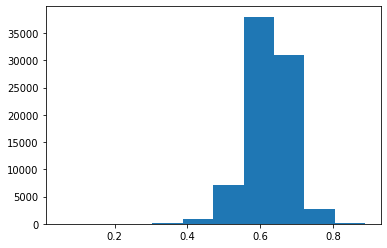

In [649]:
plt.hist(sample_exagg_preds.numpy())

In [650]:
torch.mean(abs(sample_exagg_preds - eq_preds))

tensor(0.0098)

#### Medium

In [651]:
q_los = [X_train_sample_eq[column].quantile(q=1/4) for column in columns_horse1]
q_his = [X_train_sample_eq[column].quantile(q=3/4) for column in columns_horse1]

In [652]:
q_los

[0.075,
 0.075,
 0.075,
 0.8025404403145713,
 0.7829666902316295,
 0.7829666902316295]

In [653]:
q_his

[0.2, 0.2, 0.2, 0.8163724014414827, 0.7965210841633598, 0.7967521936208257]

In [654]:
X_train_sample_exagg = X_train_sample_eq.copy()
X_train_sample_exagg.shape

(80067, 144)

In [655]:
for column, q_lo in zip(columns_horse1, q_los):
    X_train_sample_exagg[column] = q_lo

In [656]:
for column, q_hi in zip(columns_horse2, q_his):
    X_train_sample_exagg[column] = q_hi

In [657]:
X_train_sample_exagg_tensor = torch.from_numpy(X_train_sample_exagg.to_numpy()).float().to(device)

In [658]:
with torch.no_grad():
    sample_exagg_preds = torch.sigmoid(net.forward(X_train_sample_exagg_tensor))

In [659]:
sample_exagg_preds.numpy()

array([[0.6341989 ],
       [0.6853874 ],
       [0.5701057 ],
       ...,
       [0.5663731 ],
       [0.47066775],
       [0.67282754]], dtype=float32)

In [660]:
torch.mean(sample_exagg_preds)

tensor(0.6290)

(array([4.0000e+00, 1.2000e+01, 2.8000e+01, 1.6600e+02, 9.0800e+02,
        7.0540e+03, 3.6291e+04, 3.2360e+04, 3.1020e+03, 1.4200e+02]),
 array([0.0535129 , 0.13739112, 0.22126935, 0.3051476 , 0.3890258 ,
        0.47290403, 0.55678225, 0.6406605 , 0.72453874, 0.80841696,
        0.8922952 ], dtype=float32),
 <BarContainer object of 10 artists>)

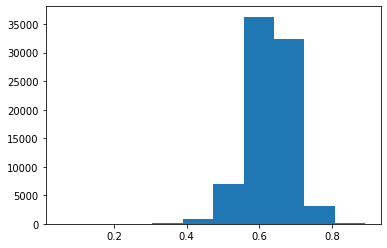

In [661]:
plt.hist(sample_exagg_preds.numpy())

In [662]:
torch.mean(abs(sample_exagg_preds - eq_preds))

tensor(0.0140)

#### High

In [663]:
q_los = [X_train_sample_eq[column].quantile(q=1/5) for column in columns_horse1]
q_his = [X_train_sample_eq[column].quantile(q=4/5) for column in columns_horse1]

In [664]:
q_los

[0.05, 0.05, 0.05, 0.8015733621876803, 0.782023198885685, 0.7819938664458573]

In [665]:
q_his

[0.225,
 0.225,
 0.225,
 0.8190859814013625,
 0.7993029653989958,
 0.7995210767801941]

In [666]:
X_train_sample_exagg = X_train_sample_eq.copy()
X_train_sample_exagg.shape

(80067, 144)

In [667]:
for column, q_lo in zip(columns_horse1, q_los):
    X_train_sample_exagg[column] = q_lo

In [668]:
for column, q_hi in zip(columns_horse2, q_his):
    X_train_sample_exagg[column] = q_hi

In [669]:
X_train_sample_exagg_tensor = torch.from_numpy(X_train_sample_exagg.to_numpy()).float().to(device)

In [670]:
with torch.no_grad():
    sample_exagg_preds = torch.sigmoid(net.forward(X_train_sample_exagg_tensor))

In [671]:
sample_exagg_preds.numpy()

array([[0.6420072 ],
       [0.69263273],
       [0.57154197],
       ...,
       [0.56781167],
       [0.4721279 ],
       [0.67411584]], dtype=float32)

In [672]:
torch.mean(sample_exagg_preds)

tensor(0.6339)

(array([2.0000e+00, 1.0000e+01, 3.1000e+01, 1.5900e+02, 8.7900e+02,
        7.0100e+03, 3.4913e+04, 3.3380e+04, 3.5310e+03, 1.5200e+02]),
 array([0.05494653, 0.13900207, 0.2230576 , 0.30711314, 0.39116868,
        0.47522423, 0.55927974, 0.6433353 , 0.7273908 , 0.81144637,
        0.8955019 ], dtype=float32),
 <BarContainer object of 10 artists>)

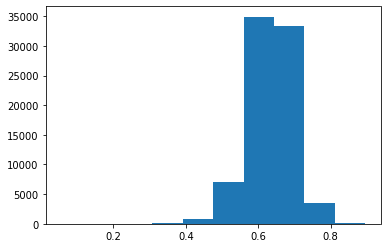

In [673]:
plt.hist(sample_exagg_preds.numpy())

In [674]:
torch.mean(abs(sample_exagg_preds - eq_preds))

tensor(0.0183)

### Humidity Races

In [675]:
columns_horse1 = [
    'horse1_jockey_prev_1_position_rhum',
    'horse1_jockey_prev_2_position_rhum',
    'horse1_jockey_prev_3_position_rhum',
    'horse1_jockey_prev_1_finishing_time_ratio_rhum',
    'horse1_jockey_prev_2_finishing_time_ratio_rhum',
    'horse1_jockey_prev_3_finishing_time_ratio_rhum',
]

In [676]:
columns_horse2 = [
    'horse2_jockey_prev_1_position_rhum',
    'horse2_jockey_prev_2_position_rhum',
    'horse2_jockey_prev_3_position_rhum',
    'horse2_jockey_prev_1_finishing_time_ratio_rhum',
    'horse2_jockey_prev_2_finishing_time_ratio_rhum',
    'horse2_jockey_prev_3_finishing_time_ratio_rhum',
]

#### Small

In [677]:
q_los = [X_train_sample_eq[column].quantile(q=1/3) for column in columns_horse1]
q_his = [X_train_sample_eq[column].quantile(q=2/3) for column in columns_horse1]

In [678]:
q_los

[0.1, 0.1, 0.1, 0.8042070714605399, 0.8040775041406559, 0.784592672682663]

In [679]:
q_his

[0.175,
 0.175,
 0.175,
 0.8128300760853349,
 0.8127401064117674,
 0.7931236971333125]

In [680]:
X_train_sample_exagg = X_train_sample_eq.copy()
X_train_sample_exagg.shape

(80067, 144)

In [681]:
for column, q_lo in zip(columns_horse1, q_los):
    X_train_sample_exagg[column] = q_lo

In [682]:
for column, q_hi in zip(columns_horse2, q_his):
    X_train_sample_exagg[column] = q_hi

In [683]:
X_train_sample_exagg_tensor = torch.from_numpy(X_train_sample_exagg.to_numpy()).float().to(device)

In [684]:
with torch.no_grad():
    sample_exagg_preds = torch.sigmoid(net.forward(X_train_sample_exagg_tensor))

In [685]:
sample_exagg_preds.numpy()

array([[0.639676  ],
       [0.6819484 ],
       [0.5796915 ],
       ...,
       [0.57444507],
       [0.4829243 ],
       [0.66911334]], dtype=float32)

In [686]:
torch.mean(sample_exagg_preds)

tensor(0.6255)

(array([5.0000e+00, 1.1000e+01, 3.1000e+01, 1.5900e+02, 1.0800e+03,
        8.4000e+03, 4.2879e+04, 2.5789e+04, 1.6000e+03, 1.1300e+02]),
 array([0.05149693, 0.13687491, 0.22225289, 0.30763087, 0.39300886,
        0.47838682, 0.5637648 , 0.6491428 , 0.73452073, 0.8198987 ,
        0.9052767 ], dtype=float32),
 <BarContainer object of 10 artists>)

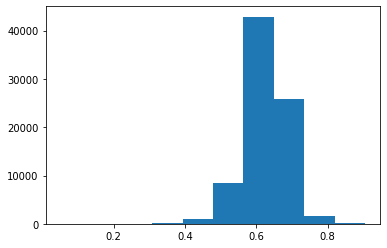

In [687]:
plt.hist(sample_exagg_preds.numpy())

In [688]:
torch.mean(abs(sample_exagg_preds - eq_preds))

tensor(0.0118)

#### Medium

In [689]:
q_los = [X_train_sample_eq[column].quantile(q=1/4) for column in columns_horse1]
q_his = [X_train_sample_eq[column].quantile(q=3/4) for column in columns_horse1]

In [690]:
q_los

[0.075,
 0.075,
 0.075,
 0.8025404403145713,
 0.8024933781493718,
 0.7829666902316295]

In [691]:
q_his

[0.2, 0.2, 0.2, 0.8163807250484857, 0.816308262824748, 0.7967521936208257]

In [692]:
X_train_sample_exagg = X_train_sample_eq.copy()
X_train_sample_exagg.shape

(80067, 144)

In [693]:
for column, q_lo in zip(columns_horse1, q_los):
    X_train_sample_exagg[column] = q_lo

In [694]:
for column, q_hi in zip(columns_horse2, q_his):
    X_train_sample_exagg[column] = q_hi

In [695]:
X_train_sample_exagg_tensor = torch.from_numpy(X_train_sample_exagg.to_numpy()).float().to(device)

In [696]:
with torch.no_grad():
    sample_exagg_preds = torch.sigmoid(net.forward(X_train_sample_exagg_tensor))

In [697]:
sample_exagg_preds.numpy()

array([[0.64727825],
       [0.68909293],
       [0.5838963 ],
       ...,
       [0.57866406],
       [0.48724055],
       [0.6729283 ]], dtype=float32)

In [698]:
torch.mean(sample_exagg_preds)

tensor(0.6314)

(array([5.0000e+00, 1.1000e+01, 2.7000e+01, 1.5100e+02, 1.0060e+03,
        7.7670e+03, 4.1151e+04, 2.7949e+04, 1.8830e+03, 1.1700e+02]),
 array([0.05227704, 0.13785739, 0.22343774, 0.3090181 , 0.39459845,
        0.4801788 , 0.5657592 , 0.65133953, 0.7369199 , 0.8225002 ,
        0.9080806 ], dtype=float32),
 <BarContainer object of 10 artists>)

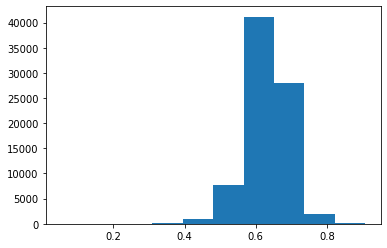

In [699]:
plt.hist(sample_exagg_preds.numpy())

In [700]:
torch.mean(abs(sample_exagg_preds - eq_preds))

tensor(0.0161)

#### High

In [701]:
q_los = [X_train_sample_eq[column].quantile(q=1/5) for column in columns_horse1]
q_his = [X_train_sample_eq[column].quantile(q=4/5) for column in columns_horse1]

In [702]:
q_los

[0.05, 0.05, 0.05, 0.8015429025546014, 0.8014535069585047, 0.782023198885685]

In [703]:
q_his

[0.225,
 0.225,
 0.225,
 0.8191120478136547,
 0.8191435483044339,
 0.7995799891878401]

In [704]:
X_train_sample_exagg = X_train_sample_eq.copy()
X_train_sample_exagg.shape

(80067, 144)

In [705]:
for column, q_lo in zip(columns_horse1, q_los):
    X_train_sample_exagg[column] = q_lo

In [706]:
for column, q_hi in zip(columns_horse2, q_his):
    X_train_sample_exagg[column] = q_hi

In [707]:
X_train_sample_exagg_tensor = torch.from_numpy(X_train_sample_exagg.to_numpy()).float().to(device)

In [708]:
with torch.no_grad():
    sample_exagg_preds = torch.sigmoid(net.forward(X_train_sample_exagg_tensor))

In [709]:
sample_exagg_preds.numpy()

array([[0.654502  ],
       [0.6958624 ],
       [0.58788645],
       ...,
       [0.5826687 ],
       [0.4913502 ],
       [0.6765379 ]], dtype=float32)

In [710]:
torch.mean(sample_exagg_preds)

tensor(0.6369)

(array([5.0000e+00, 1.1000e+01, 2.3000e+01, 1.4900e+02, 9.2300e+02,
        7.2020e+03, 3.9438e+04, 2.9999e+04, 2.1970e+03, 1.2000e+02]),
 array([0.05304252, 0.13880825, 0.224574  , 0.31033972, 0.39610547,
        0.48187122, 0.56763697, 0.6534027 , 0.7391684 , 0.8249342 ,
        0.9106999 ], dtype=float32),
 <BarContainer object of 10 artists>)

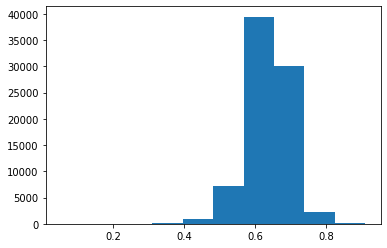

In [711]:
plt.hist(sample_exagg_preds.numpy())

In [712]:
torch.mean(abs(sample_exagg_preds - eq_preds))

tensor(0.0210)

---